In [97]:
import numpy as np
import pandas as pd
import os

datadir = os.path.join('..', 'WISDM_at_v2.0')
raw_headers = ['user','activity','time','x','y','z']
act_headers = ['user','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','XAVG','YAVG','ZAVG','XPEAK','YPEAK','ZPEAK','XABSOLDEV', 'YABSOLDEV','ZABSOLDEV','XSTANDDEV','YSTANDDEV','ZSTANDDEV','Resultant','Activity']


In [98]:
labelled_act = os.path.join(datadir,'WISDM_at_v2.0_transformed.csv')
labelled_raw = os.path.join(datadir, 'WISDM_at_v2.0_raw.txt')
raw_data = pd.read_csv(labelled_raw, header=None, names = raw_headers, parse_dates=True)
raw_data = raw_data.loc[raw_data['time']>0]
raw_data['time'] = pd.to_datetime(raw_data['time'], unit = 'ms', errors='coerce')
act_data = pd.read_csv(labelled_act, header=None, names = act_headers)

In [133]:
users = list(set(raw_data.user.unique()).intersection(set(act_data.user.unique())))
print users
time_user_raw = raw_data[['user','time']]
user_duration = time_user_raw.groupby('user').agg({'time':[min,max]})
user_duration.columns = ["_".join(x) for x in user_duration.columns.ravel()]
user_duration['duration'] = user_duration['time_max'] - user_duration['time_min']
#print user_duration.sort_values(by='duration').loc[act_data.user.unique()]['duration']
user_duration = user_duration.loc[users]
user_duration = user_duration[(user_duration['duration'].dt.total_seconds()//60.0) > 5]
users = user_duration.index

[1280, 1793, 1797, 1799, 1247, 1802, 1676, 1679, 1554, 1683, 1518, 1559, 1696, 1319, 1320, 1707, 1117, 1246, 1205, 1723, 1724, 1726, 1238, 194, 1603, 1477, 1480, 1742, 1104, 1745, 1491, 1750, 1757, 1758, 1759, 1761, 1763, 1253, 998, 1511, 1512, 1703, 1774, 1775, 1778, 1269, 1274, 1531, 1276, 1277]


In [134]:
activity_duration = {'Walking': 0, 'Jogging': 1, 'Standing': 2, 'Sitting': 3, 'Stairs': 4, 'LyingDown': 5}
user_feats = []
#users = []
#nan_users = {}
for userid in users:
    user_act_data = act_data.loc[act_data['user']==userid]['Activity']
    prev = user_act_data.iloc[0]
    #feat = [walk_dur, jog_dur, stand_dur, sit_dur, stair_dur, ly_dur, no_tx, walk_jog, walk_sit, sit_walk]
    feat = [0.0]*10
    tot_dur = 0
    for i,activity in user_act_data.iteritems():
        '''
        if activity_duration.get(activity, -1)!=-1:
            nan_users[userid] = i
        '''
        #print activity
        feat_index = activity_duration.get(activity, -1)
        if feat_index != -1:
            #print activity
            feat[feat_index] = feat[feat_index] + 1
            if activity!= prev:
                feat[6] = feat[6] + 1
                if prev=='Walking' and activity=='Jogging':
                    feat[7] = feat[7] + 1
                elif prev=='Walking' and activity=='Sitting':
                    feat[8] = feat[8] + 1
                elif prev=='Sitting' and activity=='Walking':
                    feat[9] = feat[9] + 1
            prev = activity
        tot_dur = tot_dur + 1
    ufeat = [x/tot_dur for x in feat]
    user_feats.append(ufeat)
    #users.append(userid)


In [101]:
for userid in users:
    user_act_data = act_data.loc[act_data['user']==userid]['Activity']
    print user_act_data.head()

5033    Standing
5034    Standing
5035    Standing
5036    Standing
5037    Standing
Name: Activity, dtype: object
5139    Stairs
5140    Stairs
5141    Stairs
5142    Stairs
5143    Stairs
Name: Activity, dtype: object
5148    Sitting
5149    Sitting
5150    Sitting
5151    Sitting
5152    Sitting
Name: Activity, dtype: object
5332     Walking
5333    Standing
5334     Sitting
Name: Activity, dtype: object
3885    Standing
3886    Standing
3887    Standing
3888    Standing
3889    Standing
Name: Activity, dtype: object
3165    Walking
3166    Walking
3167    Walking
3168    Walking
3169    Walking
Name: Activity, dtype: object
3201    Walking
3202    Walking
3203    Walking
3204    Walking
3205    Walking
Name: Activity, dtype: object
3987    Sitting
3988    Sitting
3989    Sitting
3990    Sitting
3991    Sitting
Name: Activity, dtype: object
1979    Walking
1980    Walking
1981    Walking
1982    Walking
1983    Walking
Name: Activity, dtype: object
2550    Sitting
2551    Sitting
25

In [135]:
print users
print len(users)
print len(user_feats)
ufeats = np.array(user_feats)
print ufeats

Int64Index([1793, 1797, 1799, 1802, 1676, 1554, 1559, 1696, 1319, 1320, 1707,
            1117, 1246, 1724, 1238,  194, 1603, 1477, 1742, 1104, 1750, 1758,
            1759, 1761, 1253,  998, 1512, 1703, 1774, 1775, 1778, 1531, 1277],
           dtype='int64', name=u'user')
33
33
[[0.28301887 0.         0.3490566  0.12264151 0.12264151 0.12264151
  0.03773585 0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.32065217 0.         0.07065217 0.51086957 0.09782609 0.
  0.01630435 0.         0.         0.00543478]
 [0.33333333 0.         0.33333333 0.33333333 0.         0.
  0.66666667 0.         0.         0.        ]
 [0.2278481  0.25316456 0.20253165 0.08860759 0.         0.2278481
  0.05063291 0.01265823 0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  

In [121]:
for userid in users:
    user_raw_data = raw_data.loc[raw_data['user']==userid]
    prev_time = user_raw_data.iloc[0]['time']
    gap = 0
    for index, attr in user_raw_data.iterrows():
        if (attr[2] - prev_time).total_seconds() > 120:
            gap = gap + 1
        prev_time = attr[2]
    print userid, gap


1793 0


KeyboardInterrupt: 

In [125]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_validate

for n in range(2,6):
    gmm = GaussianMixture(n_components=n)
    cv_results = cross_validate(gmm, user_feats, cv=10,  return_train_score=False)
    print n, cv_results

2 {'score_time': array([0.        , 0.        , 0.        , 0.00100017, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00099993]), 'test_score': array([28.5066649 , 21.72981453, 22.62567215, 21.80546888, 25.77270981,
       22.07449568, 17.64231976, 23.54725167, 20.20348692, 24.91672782]), 'fit_time': array([0.00399995, 0.00400019, 0.00399995, 0.00300002, 0.00399995,
       0.00300002, 0.00399995, 0.00300002, 0.00400019, 0.00399995])}
3 {'score_time': array([0.        , 0.        , 0.00099993, 0.        , 0.00099993,
       0.        , 0.00099993, 0.        , 0.        , 0.        ]), 'test_score': array([ 32.74093614,  32.79278838,  22.12942221,  22.87094517,
         9.74794103,  15.59110094,  27.12616339,  22.67276159,
       -14.10600955,  44.30785115]), 'fit_time': array([0.00400019, 0.00399995, 0.00500011, 0.00300002, 0.00500011,
       0.00399995, 0.00499988, 0.00300002, 0.00500011, 0.00600004])}
4 {'score_time': array([0.        , 0.        , 0.        , 0

Text(0.5,0,u'n_components')

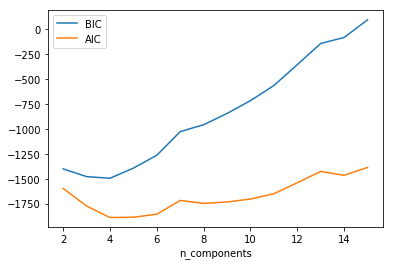

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
n_components = range(2,16)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(ufeats) for n in n_components]
plt.plot(n_components, [m.bic(ufeats) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ufeats) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [137]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN().fit(ufeats)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(ufeats, db_labels))

Estimated number of clusters: 2
Silhouette Coefficient: 0.458


In [138]:
#cluster characteristics when 5 clusters for GMM and 3 for DBSCAN
gmm = GaussianMixture(5, covariance_type='full', random_state=0).fit(ufeats)
user_labels_gmm = gmm.predict(ufeats)
print user_labels_gmm

def indices( mylist, value):
    return [i for i,x in enumerate(mylist) if x==value]

gmm_clusters = {}
for n in range(5):
   gmm_clusters[n] = indices(user_labels_gmm, n)
    
#dbscan clusters
db_clusters = {}
for n in range(2):
    db_clusters[n] = indices(db_labels, n)

print 'gmm:', gmm_clusters
print 'db:',db_clusters

[0 2 2 1 0 3 3 1 3 2 0 0 1 4 0 0 2 3 2 0 1 0 0 4 2 3 3 0 2 2 2 1 3]
gmm: {0: [0, 4, 10, 11, 14, 15, 19, 21, 22, 27], 1: [3, 7, 12, 20, 31], 2: [1, 2, 9, 16, 18, 24, 28, 29, 30], 3: [5, 6, 8, 17, 25, 26, 32], 4: [13, 23]}
db: {0: [0, 2, 4, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 30], 1: [5, 6, 8, 17, 25, 26, 32]}


In [132]:
for cluster in gmm_clusters.keys():
    users_in_cluster = gmm_clusters[cluster]
    print 'CLUSTER ', cluster
    for u in users_in_cluster:
        print users[u],':',user_feats[u]
        
print 'DBSCAN'
for cluster in db_clusters.keys():
    users_in_cluster = db_clusters[cluster]
    print 'CLUSTER ', cluster
    for u in users_in_cluster:
        print users[u],':',user_feats[u]

CLUSTER  0
1793 : [0.2830188679245283, 0.0, 0.3490566037735849, 0.12264150943396226, 0.12264150943396226, 0.12264150943396226, 0.03773584905660377, 0.0, 0.0, 0.0]
1676 : [0.22784810126582278, 0.25316455696202533, 0.20253164556962025, 0.08860759493670886, 0.0, 0.22784810126582278, 0.05063291139240506, 0.012658227848101266, 0.0, 0.0]
1707 : [0.25225225225225223, 0.11711711711711711, 0.3963963963963964, 0.11711711711711711, 0.0, 0.11711711711711711, 0.05405405405405406, 0.0, 0.0, 0.0]
1724 : [0.0, 0.0, 0.8, 0.0, 0.0, 0.2, 0.2, 0.0, 0.0, 0.0]
1238 : [0.3409090909090909, 0.0, 0.5113636363636364, 0.06818181818181818, 0.07196969696969698, 0.007575757575757576, 0.022727272727272728, 0.0, 0.0, 0.0]
194 : [0.18235294117647058, 0.11176470588235295, 0.38235294117647056, 0.07647058823529412, 0.23529411764705882, 0.011764705882352941, 0.047058823529411764, 0.0058823529411764705, 0.0, 0.0]
1104 : [0.39908256880733944, 0.13302752293577982, 0.25229357798165136, 0.10091743119266056, 0.10550458715596331,